# Iterative deconvolution of Takahashi et al. (2020) - $\mathtt{TOB20}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
from scipy.linalg import cho_factor, cho_solve
import pickle

# 3D visualization
import pyvista as pv
pv.set_jupyter_backend('panel')

from gravmag import plot_functions as plf
from gravmag import eqlayer as eql
from gravmag import convolve as conv
from gravmag import constants as cts

### Data points

In [2]:
with open('data_points.pickle', 'rb') as f:
    data_points = pickle.load(f)

In [3]:
# number of points along x and y
print(data_points['shape'])

# minimum x, maximum x, minimum y and maximum y
print(data_points['area'])

(50, 50)
[-5000, 5000, -4000, 6000]


In [4]:
data_points['coordinates'][:,:5]

array([[-5000.        , -5000.        , -5000.        , -5000.        ,
        -5000.        ],
       [-4000.        , -3795.91836735, -3591.83673469, -3387.75510204,
        -3183.67346939],
       [ -100.        ,  -100.        ,  -100.        ,  -100.        ,
         -100.        ]])

Data are y-oriented

In [5]:
# Grid spacing
dx = (data_points['area'][1] - data_points['area'][0])/(data_points['shape'][0]-1)
dy = (data_points['area'][3] - data_points['area'][2])/(data_points['shape'][1]-1)

In [6]:
dx, dy

(204.08163265306123, 204.08163265306123)

In [7]:
# total number of data
D = np.prod(data_points['shape'])

In [8]:
D

2500

In [9]:
data_points['coordinates'][2,0]

-100.0

### Noise-free gravity data

In [10]:
with open('gravity_data.pickle', 'rb') as f:
    gravity_data = pickle.load(f)

### Noise-corrupted gravity data

In [11]:
with open('gravity_data_noisy.pickle', 'rb') as f:
    gravity_data_noisy = pickle.load(f)

### Set the equivalent sources location

In [12]:
# depth of the equivalent layer
Delta_z = 3*dx
z_layer = data_points['coordinates'][2,0] + Delta_z

In [13]:
z_layer

512.2448979591837

In [14]:
data_points['coordinates'][2,0]

-100.0

### Compute the first column of sensitivity matrix

In [15]:
g0 = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
     eql.kernel_matrix_monopoles(data_points['coordinates'], z_layer, field="z", first_column=True)
)

In [16]:
# first column of the embedding BCCB matric
c0 = conv.embedding_BCCB_first_column(
    b0=g0[:,0], Q=data_points['shape'][0], P=data_points['shape'][1], symmetry='symm-symm'
)

In [17]:
# matrix of eigenvalues
L = conv.eigenvalues_BCCB(
    c0=c0, Q=data_points['shape'][0], P=data_points['shape'][1]
)

### Estimate the physical-property distribution

In [18]:
# physical-property distribution
convergence, parameters = eql.method_iterative_deconvolution_grav_TOB20(
    data=gravity_data_noisy['d20'], epsilon=1e-3, 
    L=L, Q=data_points['shape'][0], P=data_points['shape'][1], 
    ordering="row", ITMAX=50, check_input=True
    )

In [19]:
iterations = [i for i in range(len(convergence))]

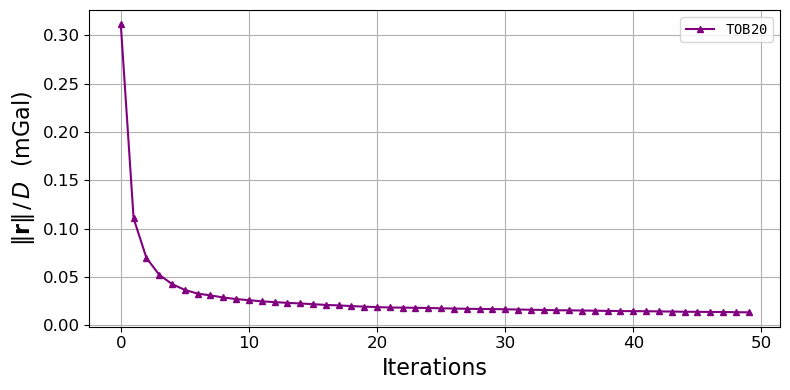

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.semilogy(iterations, convergence, linestyle='-', 
#             color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')
ax.plot(iterations, convergence, linestyle='-', 
        color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\Vert \mathbf{r} \Vert \, \slash \, D$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
#plt.savefig('../manuscript/Fig/convergence_TOB20.png', dpi= 300)
plt.show()

In [21]:
# data predicted by the estimated equivalent layer
predicted_gz = conv.product_BCCB_vector(
    L=L, Q=data_points['shape'][0], P=data_points['shape'][1], v=parameters
)

In [22]:
# residuals vector
residuals_data = predicted_gz - gravity_data_noisy['d20']

### Plot the data fit

In [23]:
ranges_data = np.max(np.abs(gravity_data_noisy['d20']))
ranges_res = np.max(np.abs(residuals_data))

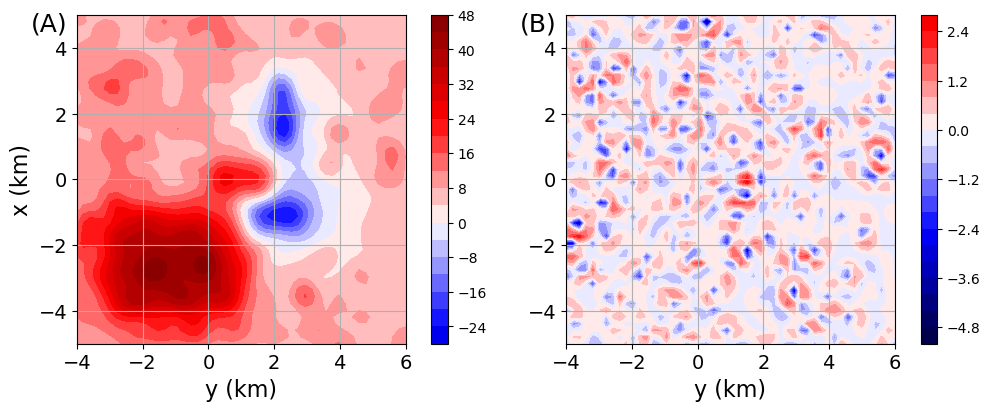

In [24]:
fig = plt.figure(layout= 'constrained', figsize=(10,4))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
ax = mosaic['a']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                 predicted_gz.reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_data, vmax=ranges_data)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(A)', xy=(-0.14, 0.95), xycoords='axes fraction', fontsize=18)
mosaic['a'].set_ylabel('x (km)', fontsize=16)
mosaic['a'].set_xlabel('y (km)', fontsize=16)

ax = mosaic['b']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                 residuals_data.reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_res, vmax=ranges_res)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(B)', xy=(-0.14, 0.95), xycoords='axes fraction', fontsize=18)
#mosaic['b'].set_ylabel('x (km)', fontsize=16)
mosaic['b'].set_xlabel('y (km)', fontsize=16)

plt.show()

### Plot the residuals

In [25]:
tensor_components = ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']

symmetries = ['symm-symm', 'skew-skew', 'skew-symm', 'symm-symm', 'symm-skew', 'symm-symm']

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']

mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

In [26]:
residuals = dict()
residuals['gz'] = residuals_data

# residuals tensor components
for (tensor_component, symmetry) in zip(tensor_components, symmetries):
    # kernel matrix associated with the equivalent layer
    g0 = cts.GRAVITATIONAL_CONST*cts.SI2EOTVOS*(
         eql.kernel_matrix_monopoles(data_points['coordinates'], 
                                     z_layer, field=tensor_component, first_column=True
                                    )
    )
    # first column of the embedding BCCB matric
    c0 = conv.embedding_BCCB_first_column(
        b0=g0[:,0], Q=data_points['shape'][0], P=data_points['shape'][1], symmetry=symmetry
    )
    # matrix of eigenvalues
    L = conv.eigenvalues_BCCB(
        c0=c0, Q=data_points['shape'][0], P=data_points['shape'][1]
    )
    # data predicted by the estimated equivalent layer
    predicted_data = conv.product_BCCB_vector(
        L=L, Q=data_points['shape'][0], P=data_points['shape'][1], v=parameters
    )
    residuals['g{}'.format(tensor_component)] = predicted_data - gravity_data['g{}'.format(tensor_component)]

In [27]:
# compute ranges
ranges_gz = np.max(np.abs(residuals['gz']))
ranges_tensor = []
for tensor_component in tensor_components:
    ranges_tensor.append(np.max(np.abs(residuals['g{}'.format(tensor_component)])))
ranges_tensor = 0.9*np.max(ranges_tensor)

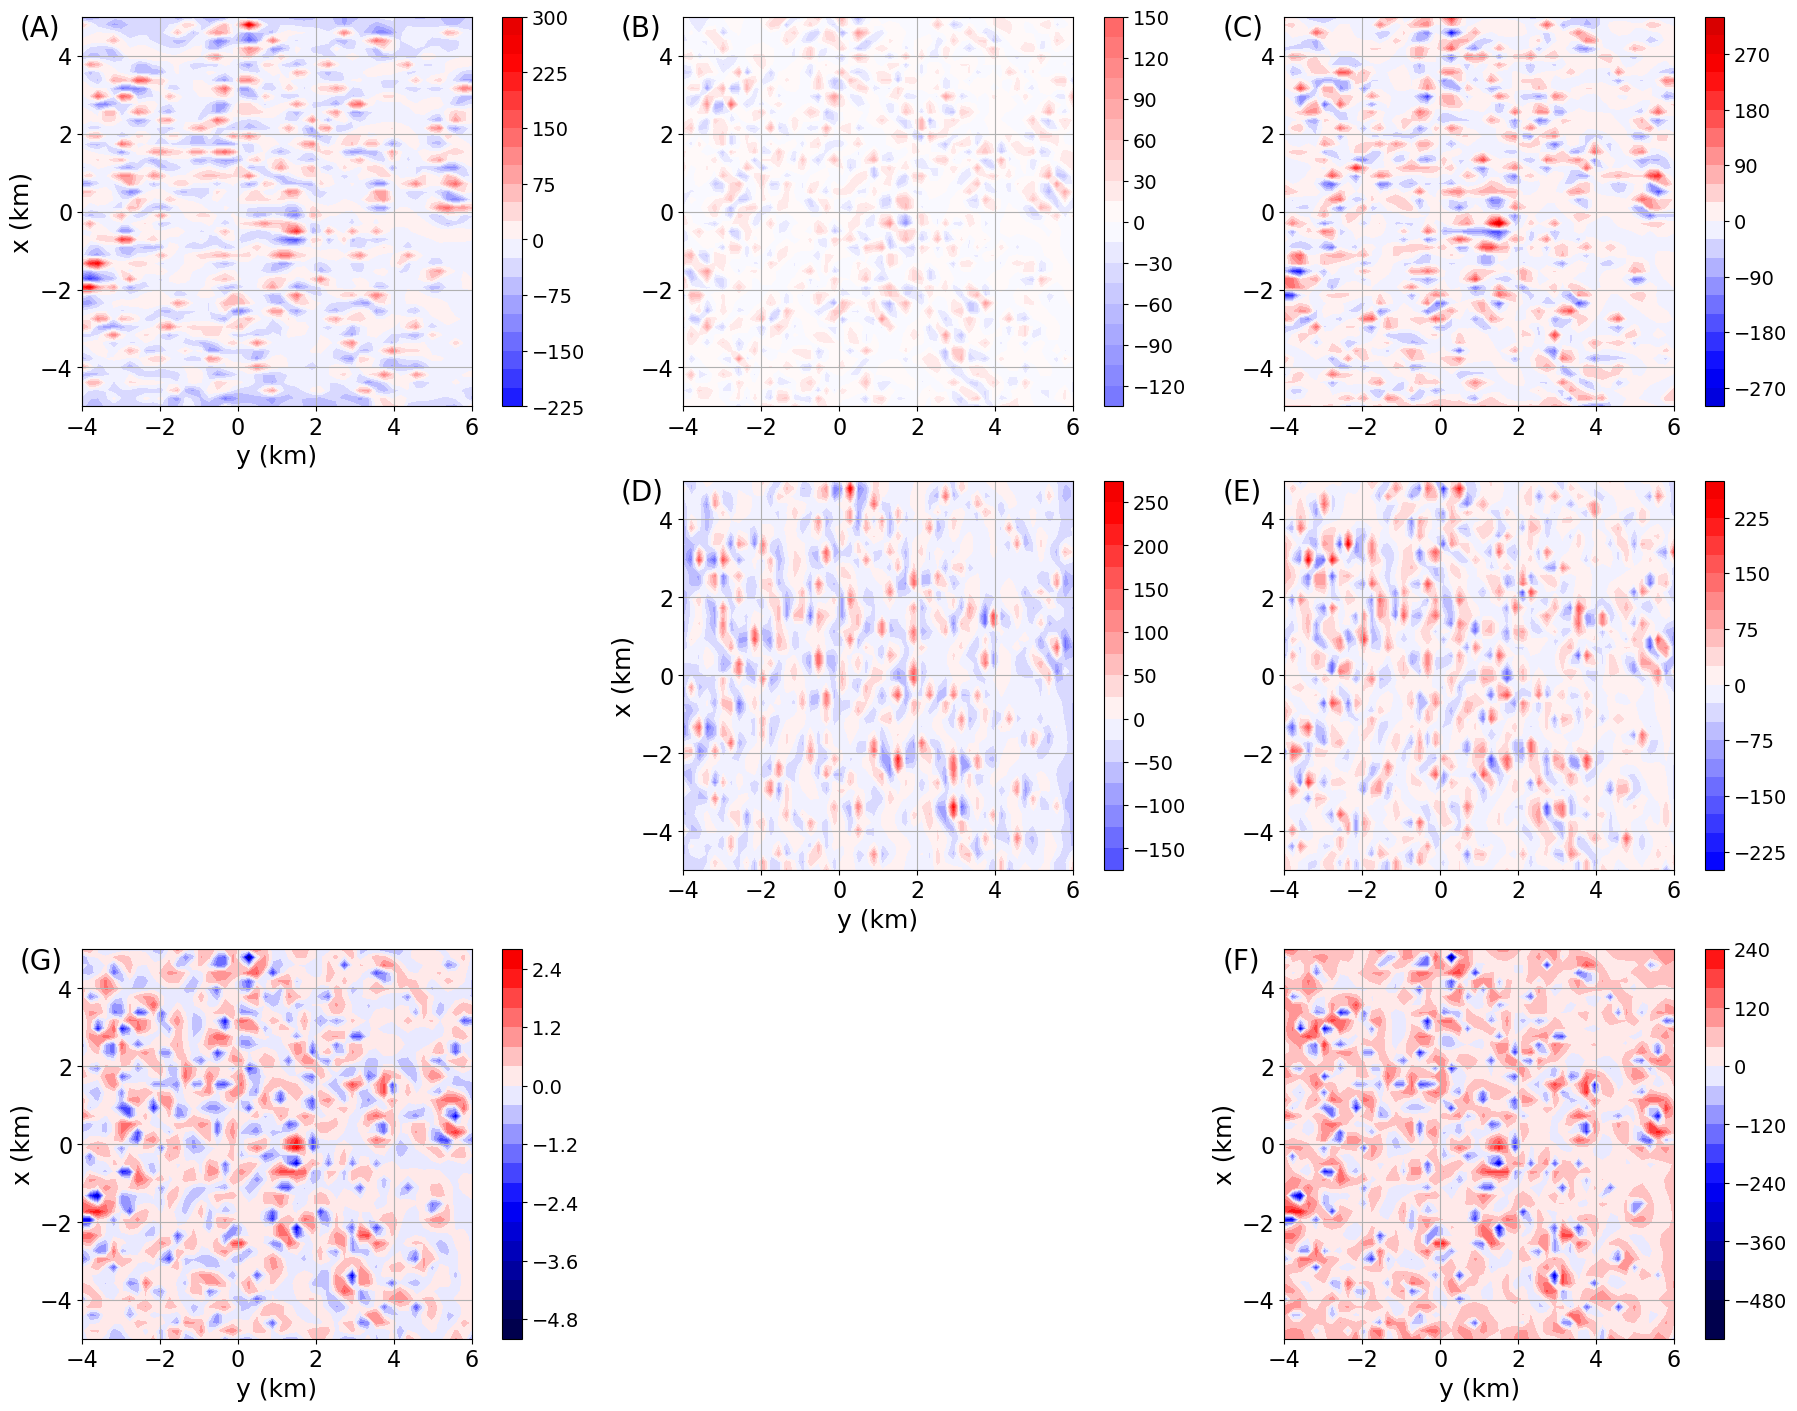

In [29]:
# plot figure
fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label) in zip(
    mosaic_elements, tensor_components, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                     data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                     residuals['g{}'.format(tensor_component)].reshape(data_points['shape']), 20, 
                     cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

# gz
ax = mosaic['g']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                 residuals['gz'].reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_gz, vmax=ranges_gz)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.savefig('TOB20_residuals.png', dpi= 300)
plt.show()